<a href="https://colab.research.google.com/github/Esselle7/Model-Identification-with-Sindy/blob/main/signalPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import e download delle librerie

In [1]:
import matplotlib.pyplot as plt
import math
from typing import List
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.signal import medfilt
import csv
from typing import Tuple

In [2]:
!apt-get install graphviz libgraphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
!pip install git+https://github.com/LesLivia/lsha.git

  Cloning https://github.com/LesLivia/lsha.git to /tmp/pip-req-build-uwo9y9be
  Running command git clone --filter=blob:none --quiet https://github.com/LesLivia/lsha.git /tmp/pip-req-build-uwo9y9be
  Resolved https://github.com/LesLivia/lsha.git to commit 9ac04d9f25688ba0f2c4bef91d767aedd57e87ef
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install pykalman

In [5]:
!pip install xgboost

In [6]:
!pip install tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:00


In [7]:
!pip install scikeras

  Using cached scikeras-0.13.0-py3-none-any.whl (26 kB)
  Using cached keras-3.2.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [8]:
!pip install pysindy

  Using cached pysindy-1.7.5-py3-none-any.whl (121 kB)


##Domande

##Import classi e funzioni

In [9]:
# Importo la classe Timestamp da L*SHA con le relative costanti
DAYS_PER_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
CLOSED_R = 100.0
OFF_DISTR = (100.0, 1.0, 200)
ON_DISTR = (0.7, 0.01, 200)
class Timestamp:
    def __init__(self, y: int, m: int, d: int, h: int, min: int, sec: float):
        self.year = y
        self.month = m
        self.day = d
        self.hour = h
        self.min = min
        self.sec = sec

    @staticmethod
    def from_secs(secs: int):
        new_ts = Timestamp(int(secs / (365 * 24 * 3600)), 0, 0, 0, 0, 0)
        if secs > 365 * 24 * 3600:
            secs -= new_ts.year * 365 * 24 * 3600
        sum_d = 0
        for i, month_d in enumerate(DAYS_PER_MONTH):
            sum_d += month_d
            if secs <= sum_d * 24 * 3600:
                new_ts.month = i + 1
                secs -= (sum_d - month_d) * 24 * 3600
                break
        new_ts.day = int(secs / (24 * 3600)) + 1
        secs -= (new_ts.day - 1) * 24 * 3600
        new_ts.hour = int(secs / 3600)
        secs -= new_ts.hour * 3600
        new_ts.min = int(secs / 60)
        new_ts.sec = secs - new_ts.min * 60
        return new_ts

    def to_secs(self):
        months = sum(DAYS_PER_MONTH[:self.month - 1]) if self.month > 0 else 0
        days = self.year * 365 + months + self.day - 1 if self.day > 0 else 0
        minutes = self.hour * 60 + self.min
        seconds = minutes * 60 + self.sec
        return days * 24 * 3600 + seconds

    def __str__(self):
        return '{}/{}/{} {}:{}:{}'.format(self.day, self.month, self.year, self.hour, self.min, self.sec)

    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        return self.to_secs() == other.to_secs()

    def __ge__(self, other):
        return self.to_secs() >= other.to_secs()

    def __lt__(self, other):
        return self.to_secs() < other.to_secs()

    def __sub__(self, other):
        return self.to_secs() - other.to_secs()
class SignalPoint:
    def __init__(self, t: Timestamp, val: float):
        self.timestamp = t
        self.value = val

    def __str__(self):
        return '{}: {}'.format(self.timestamp, self.value)

    def __eq__(self, other):
        return self.timestamp == other.timestamp and self.value == other.value


class SampledSignal:
    def __init__(self, pts: List[SignalPoint], label=None):
        self.label = label
        self.points = pts

def parse_ts(string: str):
    date = string.split('T')[0]
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:10])
    time = string.split('T')[1].split('Z')[0]
    hour = int(time[0:2])
    minute = int(time[3:5])
    second = int(time[6:8])
    return Timestamp(year, month, day, hour, minute, second)

In [10]:
def parse_data(path: str):
    # support method to parse traces sampled by ref query
    power: SampledSignal = SampledSignal([], label='P')
    speed: SampledSignal = SampledSignal([], label='w')
    pressure: SampledSignal = SampledSignal([], label='pr')
    toolID: SampledSignal = SampledSignal([], label='id')
    speed_derivative: SampledSignal = SampledSignal([], label='wd')

    with open(path) as csv_file:
        reader = csv.DictReader(csv_file, delimiter=';')

        for i, row in enumerate(reader):
            # to skip the columns name row
            if i == 0:
                continue

            # select the timestamp from column 0
            ts = parse_ts(row['_time'])

            # parse power value
            power.points.append(SignalPoint(ts, float(row['Total_power'])))

            # parse speed value: round to closest [100]
            speed_v = round(float(row['actual_Speed_SP1']) / 100) * 100
            speed.points.append(SignalPoint(ts, speed_v))

            # parse pallet pressure value
            pressure.points.append(SignalPoint(ts, float(row['Pressure'])))

            # parse tool ID value
            toolID.points.append(SignalPoint(ts, float(row['dictID'])))

            # parse a signal which represents the derivative of the speed vector
            if i > 0:
                if round(speed.points[i-2].value) == round(speed.points[i-1].value):  # if constant
                    speed_d = 0
                elif round(speed.points[i-2].value) < round(speed.points[i-1].value):  # if going up
                    speed_d = 1
                else:  # if going down
                    speed_d = -1
                speed_derivative.points.append(SignalPoint(ts, float(speed_d)))

        return [power, speed, pressure, toolID, speed_derivative]

In [11]:
SPEED_RANGE = 100
MIN_SPEED = 100
MAX_SPEED = 10000
PR_RANGE = 500

class Event:
    def __init__(self, guard, chan, symb):
        self.guard = guard
        self.chan = chan
        self.symbol = symb
        self.label = guard + ',' + chan if len(guard) > 0 else chan

    def __str__(self):
        return self.label

    def __eq__(self, other):
        return self.guard == other.guard and self.chan == other.chan

    def __hash__(self):
        return hash(self.label)

# define events as different velocities ranges and stop, load and unload
events: List[Event] = []
for i in range(MIN_SPEED, MAX_SPEED, SPEED_RANGE):
    if i < MAX_SPEED - SPEED_RANGE:
        new_guard = '{}<=w<{}'.format(i, i + SPEED_RANGE)
    else:
        new_guard = '{}<=w'.format(i)
    events.append(Event(new_guard, 'start', 'm_{}'.format(len(events))))

spindle_off = Event('', 'stop', 'i_0')

events.append(spindle_off)
events.append(Event('', 'load', 'l'))
events.append(Event('', 'unload', 'u'))

In [12]:
EMPTY_STRING = '\u03B5'
class TimedTrace:
    def __init__(self, t: List[Timestamp], e: List[Event]):
        self.t = t
        self.e = e

    def __eq__(self, other):
        return all([ts == other.t[i] and self.e[i] == other.e[i] for i, ts in enumerate(self.t)])

    def __len__(self):
        return len(self.t)


class Trace:
    def __init__(self, events: List[Event] = None, tt: TimedTrace = None):
        if tt is not None:
            self.events = tt.e
        else:
            self.events = events

    def __str__(self):
        if len(self.events) == 0:
            return EMPTY_STRING
        else:
            return ''.join([e.symbol for e in self.events])

    def __eq__(self, other):
        return str(self) == str(other)

    def __len__(self):
        return len(self.events)

    def __getitem__(self, item):
        return self.events[item]

    def __add__(self, other):
        return Trace(events=self.events + other.events)

    def sub_prefix(self, prefix):
        return Trace(events=self.events[len(prefix.events):])

    def __hash__(self):
        return hash(str(self))

    def get_prefixes(self):
        prefixes: List[Trace] = []
        for i in range(len(self)):
            if i == 0:
                prefixes.append(Trace([self[0]]))
            else:
                prefixes.append(Trace(self[:i + 1]))
        return prefixes

    def startswith(self, word):
        if len(word) > len(self):
            return False

        for i, e in enumerate(word):
            if self.events[i].symbol != e.symbol:
                return False
        else:
            return True

def process_data(self, path):
    new_signals: List[SampledSignal] = self.parse_f(path)
    self.signals.append(new_signals)

    driver_sig = [sig for sig in new_signals if sig.label in self.driver]

    chg_pts = self.find_chg_pts(driver_sig)
    events = [self.label_f(self.events, new_signals, pt.t) for pt in chg_pts]
    new_tt = TimedTrace([pt.t for pt in chg_pts], events)
    self.timed_traces.append(new_tt)
    self.traces.append(Trace(tt=new_tt))

In [13]:
def label_event(events: List[Event], signals: List[SampledSignal], t: Timestamp):
    speed_sig = signals[1]
    pressure_sig = signals[2]
    speed = {pt.timestamp: (i, pt.value) for i, pt in enumerate(speed_sig.points)}
    pressure = {pt.timestamp: (i, pt.value) for i, pt in enumerate(pressure_sig.points)}

    # create a list of tuples where each tuple contains the limits of a speed interval
    SPEED_INTERVALS: List[Tuple[int, int]] = []
    for i in range(MIN_SPEED, MAX_SPEED, SPEED_RANGE):
        if i < MAX_SPEED - SPEED_RANGE:
            SPEED_INTERVALS.append((i, i + SPEED_RANGE))
        else:
            SPEED_INTERVALS.append((i, None))

    # identify the current and previous speed wrt the given timestamp t
    curr_speed_index, curr_speed = speed[t]
    if curr_speed_index > 0:
        try:
            prev_index = [tup[0] for tup in speed.values() if tup[0] < curr_speed_index][-1]
            prev_speed = speed_sig.points[prev_index].value
        except IndexError:
            prev_speed = None
    else:
        prev_speed = curr_speed

    # identify the current and previous pressure wrt the given timestamp t
    curr_press_index, curr_press = pressure[t]
    if curr_press_index > 0:
        try:
            prev_index = [tup[0] for tup in pressure.values() if tup[0] < curr_press_index][-1]
            prev_press = pressure_sig.points[prev_index].value
        except IndexError:
            prev_press = None
    else:
        prev_press = curr_press

    identified_event = None

    # if there is a pressure change, there is a load or unload event
    if curr_press != prev_press:
        # from 0 to 1 -> load
        if curr_press == 1.0 and prev_press == 0.0:
            identified_event = events[-2]
        # from 1 to 0 -> unload
        else:
            identified_event = events[-1]
    # if the previous velocity is bigger than the current one, we are going to 0 and we need to identify a stop event
    elif curr_speed < prev_speed:
        identified_event = events[-3]
    else:
        i = curr_speed_index
        while i < speed.__len__():
            const_speed = speed_sig.points[i].value
            if const_speed == speed_sig.points[i + 1].value and const_speed != 0:
                break
            else:
                i += 1
        # if the spindle is moving, return the constant speed that it will reach as a set point
        for i, interval in enumerate(SPEED_INTERVALS):
            if interval[0] <= const_speed <= interval[1]:
                identified_event = events[i]

    #if identified_event is None:
        #LOGGER.error("No event was identified at time {}.".format(t))

    return identified_event

In [14]:
def is_chg_pt(curr, prev):
    speed_cond = False
    if (curr[3] == 1 and prev[3] == 0) or (curr[3] == -1 and prev[3] == 0) or (curr[3] == 1 and prev[3] == -1):
        speed_cond = True
    return speed_cond or curr[1] != prev[1]

##Funzioni per elaborazione segnali

In [15]:
DRIVER_SIG = ['w', 'pr', 'id', 'wd']
DEFAULT_M = 0
DEFAULT_DISTR = 0

base_path="/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN/"
data_paths = [base_path+"_03_mar_1.csv",
                base_path+"_05_may_1.csv",
                base_path+"_05_may_2.csv",
                base_path+"_11_jan_2.csv",
                base_path+"_12_apr_1.csv",
                base_path+"_12_apr_2.csv",
                base_path+"_12_jan_2.csv",
                base_path+"_12_jan_3.csv",
                base_path+"_12_jan_4.csv",
                base_path+"_12_jan_5.csv"
                ]

In [16]:
import configparser
import os
from typing import List

from sha_learning.domain.lshafeatures import Event, NormalDistribution, Trace
from sha_learning.domain.sigfeatures import Timestamp, SampledSignal
from sha_learning.domain.sulfeatures import SystemUnderLearning, RealValuedVar, FlowCondition

config = configparser.ConfigParser()  # open the configuration file
config.sections()
config.read('./resources/config/config.ini')
config.sections()

[]

In [17]:
def get_power_param(segment: List[SignalPoint], flow: FlowCondition):
    sum_power = sum([pt.value for pt in segment])
    avg_power = sum_power / len(segment)
    return avg_power

In [18]:
def pwr_model(interval: List[Timestamp], P_0):
    interval = [ts.to_secs() for ts in interval]
    AVG_PW = 1.0
    return [AVG_PW] * len(interval)


# define flow conditions
on_fc: FlowCondition = FlowCondition(0, pwr_model)

# define distributions
off_distr = NormalDistribution(0, 0.0, 0.0)

model2distr = {0: []}
power = RealValuedVar([on_fc], [], model2distr, label='P')

# define events as different velocities ranges and stop, load and unload
events: List[Event] = []
for i in range(MIN_SPEED, MAX_SPEED, SPEED_RANGE):
    if i < MAX_SPEED - SPEED_RANGE:
        new_guard = '{}<=w<{}'.format(i, i + SPEED_RANGE)
    else:
        new_guard = '{}<=w'.format(i)
    events.append(Event(new_guard, 'start', 'm_{}'.format(len(events))))

spindle_off = Event('', 'stop', 'i_0')

events.append(spindle_off)
events.append(Event('', 'load', 'l'))
events.append(Event('', 'unload', 'u'))

DRIVER_SIG = ['w', 'pr', 'id', 'wd']
DEFAULT_M = 0
DEFAULT_DISTR = 0

args = {'name': 'energy', 'driver': DRIVER_SIG, 'default_m': DEFAULT_M, 'default_d': DEFAULT_DISTR}
energy_made_cs = SystemUnderLearning([power], events, parse_data, label_event, get_power_param, is_chg_pt, args=args)


In [19]:
def double_plot(timestamps1, v1, timestamps2, v2, t: TimedTrace, title, filtered=False, timestamps3=None, v3=None):
    subplots = 2 if timestamps3 is None else 3
    fig, axs = plt.subplots(subplots, figsize=(60, 30), gridspec_kw={'height_ratios': [3, 3, 3]})

    SIG_WIDTH = 2.0

    t1 = [x.to_secs() for x in timestamps1]
    # t1 = [i for i, x in enumerate(timestamps1)]
    axs[0].plot(t1, v1, 'k-', label='power', linewidth=SIG_WIDTH)
    axs[0].plot(t1, [0] * len(v1), 'k--', linewidth=.5)

    t2 = [x.to_secs() for x in timestamps2]
    # t2 = [i for i, x in enumerate(timestamps2)]
    axs[1].plot(t2, v2, 'k-', label='speed', linewidth=SIG_WIDTH)
    axs[1].plot(t2, [0] * len(v2), 'k-', linewidth=.5)

    if timestamps3 is not None:
        t3 = [x.to_secs() for x in timestamps3]
        # t3 = [i for i, x in enumerate(timestamps3)]
        axs[2].plot(t3, v3, 'k-', label='pressure', linewidth=SIG_WIDTH)
        axs[2].plot(t3, [0] * len(v3), 'k-', linewidth=.5)

    LABEL_FONT = 32
    TICK_FONT = 30
    EVENT_FONT = 22
    EVENT_WIDTH = 2.0
    TITLE_FONT = 38
    MARKER_SIZE = 30

    HEIGHT1 = max(v1) + 1
    HEIGHT2 = max(v2) + 100
    HEIGHT3 = max(v3) + 100

    colors = ['orange', 'b', 'green', 'red']
    labels = ['spindle start', 'spindle stop', 'pressure up', 'pressure down']

    marker = 'x'
    height1 = HEIGHT1
    height2 = HEIGHT2
    height3 = HEIGHT3

    i = 0
    labels = [e.symbol for e in t.e]
    events = [ts.to_secs() for ts in t.t]
    print(labels)
    # events = [[i for i in t1 if timestamps1[i].to_secs() == e_t.to_secs()][0] for e_t in t.t]
    axs[0].vlines(events, [0] * len(events), [height1] * len(events), color=colors[i], linewidth=EVENT_WIDTH)
    for i, e in enumerate(events):
        if labels[i] == 'l':
            color = colors[2]
            marker = '^'
        elif labels[i] == 'u':
            color = colors[3]
            marker = 'v'
        elif labels[i] == 'i_0':
            color = colors[1]
            marker = 'v'
        else:
            color = colors[0]
            marker = '^'
        axs[0].plot(e, height1, marker, color=color, label=labels[i], markersize=MARKER_SIZE)
        axs[0].vlines(e, 0, height1, color='k', linewidth=EVENT_WIDTH)
        #axs[0].text(e, height1, labels[i], fontsize=EVENT_FONT)
    # axs[0].plot(events[1:-1], [0] * (len(events) - 2), color='k', linewidth=50, zorder=1)
    # ops = ['26', '14', '16', '4', '26', '2']
    # i_op = 0
    i = 0
    # axs[2].plot(events, [height2] * len(events), marker, color=colors[i], label=labels[i])
    # axs[2].vlines(events, [0] * len(events), [height2] * len(events), color=colors[i], linewidth=EVENT_WIDTH)
    for i, e in enumerate(events):
        if labels[i] in ['l', 'u']:
            continue

        if labels[i] == 'i_0':
            color = colors[1]
            marker = 'v'
        else:
            color = colors[0]
            marker = '^'
        axs[1].plot(e, height2, marker, color=color, label=labels[i], markersize=MARKER_SIZE)
        axs[1].vlines(e, 0, height2, color='k', linewidth=EVENT_WIDTH)
        # axs[0].vlines(e, -0.1, +0.1, color='white', linewidth=8, zorder=4)
        # if labels[i] not in ['l', 'u', 'i_0']:
        # print('{}: {}'.format(ops[i_op], e + (events[i + 1] - e)))
        # axs[0].text(e + (events[i + 1] - e) / 2, -0.05, ops[i_op], color='white', zorder=4, fontsize=40)
        # i_op += 1
        # axs[2].text(e, height2, labels[i], fontsize=EVENT_FONT)

    i = 0
    # axs[3].plot(events, [height3] * len(events), marker, color=colors[i], label=labels[i])
    # axs[3].vlines(events, [0] * len(events), [height3] * len(events), color=colors[i], linewidth=EVENT_WIDTH)
    for i, e in enumerate(events):
        if labels[i].startswith('i') or labels[i].startswith('m'):
            continue
        if labels[i] == 'l':
            color = colors[2]
            marker = '^'
        else:
            color = colors[3]
            marker = 'v'
        axs[2].plot(e, height3, marker, color=color, label=labels[i], markersize=MARKER_SIZE)
        axs[2].vlines(e, 0, height3, color='k', linewidth=EVENT_WIDTH)
        # axs[3].text(e, height3, labels[i], fontsize=EVENT_FONT)

    PAD = 0.1

    step = 300
    xticks = [str(x.hour) + ':' + str(x.min).zfill(2) for x in timestamps1][::step]
    # xticks = [str(x) for x in t1][::step] + [str(t1[-1])]
    # axs[1].set_xticks(ticks=[int(o) for o in xticks])
    axs[0].set_xticks(ticks=[x for x in t1[::step]])
    axs[0].set_xticklabels(labels=xticks, fontsize=TICK_FONT)
    xmin, xmax = axs[0].get_xlim()
    axs[0].set_xlim(xmin - PAD, xmax)
    yticks = np.arange(0, max(v1) + 1, 1)
    axs[0].set_yticks(ticks=yticks)
    axs[0].set_yticklabels(labels=yticks, fontsize=TICK_FONT)
    ymin, ymax = axs[0].get_ylim()
    axs[0].set_ylim(0, ymax)

    # step = 60
    xticks = [str(x.hour) + ':' + str(x.min).zfill(2) for x in timestamps2][::step]
    # axs[2].set_xticks(ticks=[int(o) for o in xticks])
    axs[1].set_xticks(ticks=[x for x in t1[::step]])
    axs[1].set_xticklabels(labels=xticks, fontsize=TICK_FONT)
    xmin, xmax = axs[1].get_xlim()
    axs[1].set_xlim(xmin - PAD, xmax)
    yticks = np.arange(0, max(v2) + 400, 400)
    axs[1].set_yticks(ticks=yticks)
    axs[1].set_yticklabels(labels=yticks, fontsize=TICK_FONT)
    ymin, ymax = axs[1].get_ylim()
    axs[1].set_ylim(0, ymax)

    # step = 120
    xticks = [str(x.hour) + ':' + str(x.min).zfill(2) for x in timestamps3][::step]
    # axs[3].set_xticks(ticks=[int(o) for o in xticks])
    axs[2].set_xticks(ticks=[x for x in t1[::step]])
    axs[2].set_xticklabels(labels=xticks, fontsize=TICK_FONT)
    xmin, xmax = axs[2].get_xlim()
    axs[2].set_xlim(xmin - PAD, xmax)
    yticks = np.arange(0, max(v3) + 1, 800)
    axs[2].set_yticks(ticks=yticks)
    # axs[2].set_yticklabels(labels=['unlocked', 'locked'], fontsize=TICK_FONT)
    ymin, ymax = axs[2].get_ylim()
    axs[2].set_ylim(0, ymax)

    # axs[0].set_xticks(ticks=[int(o) for o in xticks])
    # axs[0].set_xticklabels(labels=xticks, fontsize=TICK_FONT)
    # axs[0].set_yticks(ticks=[0])
    # axs[0].set_yticklabels(labels=['OP'], fontsize=TICK_FONT)
    # axs[0].set_xlabel('t [s]', fontsize=LABEL_FONT)
    # axs[0].set_ylabel('', fontsize=LABEL_FONT)
    # axs[0].set_title('Operation ID', fontsize=TITLE_FONT)

    # axs[1].set_xlim(t1[0], t1[-1])
    axs[0].set_xlabel('t [hh:mm]', fontsize=LABEL_FONT)
    axs[0].set_ylabel('[kW]', fontsize=LABEL_FONT)
    axs[0].set_title('Potenza Totale', fontsize=TITLE_FONT)

    # axs[2].set_xlim(t1[0], t1[-1])
    axs[1].set_xlabel('t [hh:mm]', fontsize=LABEL_FONT)
    axs[1].set_ylabel('[rpm]', fontsize=LABEL_FONT)
    axs[1].set_title('Velocità Mandrino', fontsize=TITLE_FONT)

    # axs[3].set_xlim(t1[0], t1[-1])
    axs[2].set_xlabel('t [hh:mm]', fontsize=LABEL_FONT)
    axs[2].set_ylabel('', fontsize=LABEL_FONT)
    axs[2].set_title('Pressione', fontsize=TITLE_FONT)

    # axs[1].legend(fontsize=20)
    # axs[2].legend(fontsize=20)

    plt.tight_layout(pad=10.0)
    #fig.savefig(SAVE_PATH + '{}.pdf'.format(title))

    del fig, axs


In [20]:
def extractTimestamps(points):
  return [str(point.timestamp).split(' ', 1)[1] for point in points]

def transform_times_to_seconds_cumulative(times):
    # Converte i tempi nel formato 'HH:MM:SS' in secondi totali
    times_seconds = [sum(int(x) * 60**i for i, x in enumerate(reversed(time.split(':')))) for time in times]
    # Calcola il tempo cumulativo trascorso dal primo elemento
    times_transformed = [time - times_seconds[0] for time in times_seconds]
    return np.array(times_transformed)

In [46]:
from pykalman import KalmanFilter
def generateData(data_path):
  new_signals: List[SampledSignal] = parse_data(data_path)
  chg_pts = energy_made_cs.find_chg_pts([sig for sig in new_signals if sig.label in DRIVER_SIG])
  power_pts = new_signals[0].points
  speed_pts = new_signals[1].points
  pressure_pts = new_signals[2].points
  power_values = [pt.value for pt in power_pts]
  id_events = [label_event(events, new_signals, pt.t) for pt in chg_pts[:10]]
  energy_made_cs.process_data(data_path)
  trace = energy_made_cs.timed_traces[-1]
  kf = KalmanFilter(transition_matrices=[1],
                observation_matrices=[1],
                initial_state_mean=power_values[0],
                initial_state_covariance=1,
                observation_covariance=1,
                transition_covariance=0.01)
  smoothed_power, _ = kf.filter(power_values)
  for i, pt in enumerate(power_pts):
      pt.value = smoothed_power[i]
  power_data = np.array([pt.value for pt in power_pts]).ravel()
  speed_data = np.array([pt.value for pt in speed_pts]).ravel()
  t_power = transform_times_to_seconds_cumulative(np.array(extractTimestamps(power_pts)))
  t_speed = transform_times_to_seconds_cumulative(np.array(extractTimestamps(speed_pts)))
  #double_plot([pt.timestamp for pt in power_pts], [pt.value for pt in power_pts],
   #       [pt.timestamp for pt in speed_pts], [pt.value for pt in speed_pts],
    #      trace, title="file", filtered=True,
     #     timestamps3=[pt.timestamp for pt in pressure_pts],
      #    v3=[pt.value for pt in pressure_pts])
  return power_data, speed_data, t_power

In [47]:
power_datas = []
speed_datas = []
ts = []

for dp in data_paths:
  pd, sd, t = generateData(dp)
  power_datas.append(pd)
  speed_datas.append(sd)
  ts.append(t)

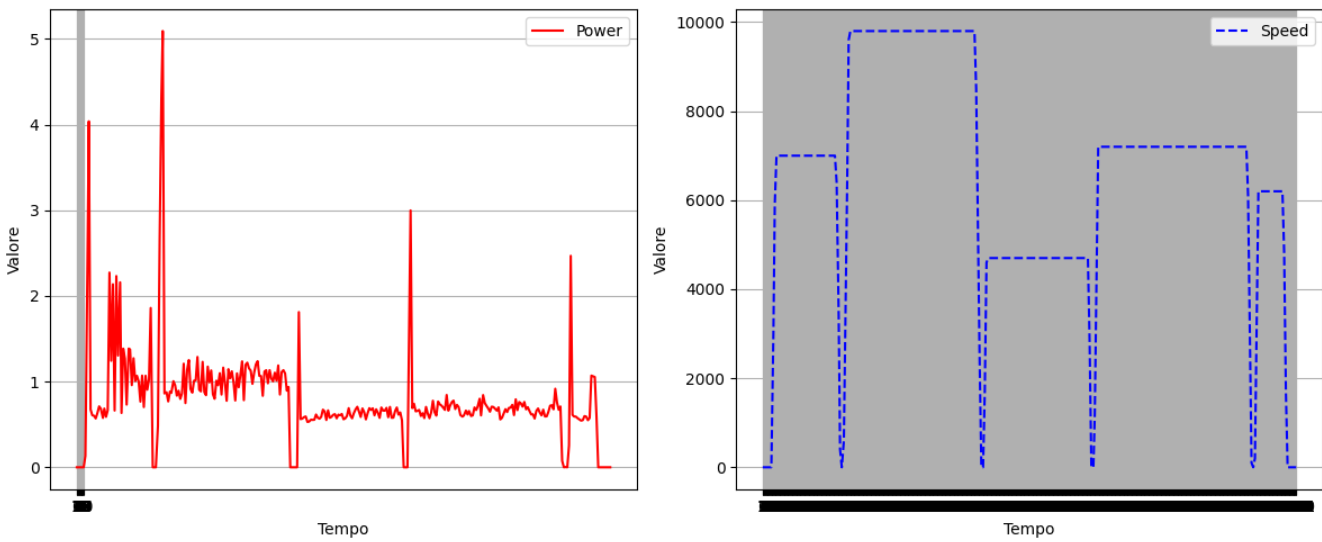

##Pre processing dei dati

In [73]:
def train_test_split(speed_datas, power_datas, ts, train_size):
  train_size = int(len(speed_datas)*train_size)
  return speed_datas[:train_size], speed_datas[train_size:], power_datas[:train_size], power_datas[train_size:], ts[:train_size], ts[train_size:]

In [110]:
train_speed, test_speed, train_power, test_power, train_ts, test_ts = train_test_split(speed_datas, power_datas, ts ,train_size=0.9)
x_train = []
for speed, power in zip(train_speed, train_power):
  x = np.column_stack((speed,power))
  x_train.append(x)
x_test = np.column_stack((test_speed[0],test_power[0]))
print(x_test.shape)


(495, 2)


###Suddivisione in segmenti

In [28]:
# Lista per memorizzare gli eventi e le relative parti di segnale
event_segments = []

def extractSegments(chg_pts, speed_pts, power_pts, events):
# Iteriamo su ogni changin point per identificare gli eventi
  for i in range(1, len(chg_pts) - 1):
    # Estraiamo i changin points consecutivi
      cp_start = chg_pts[i]
      cp_end = chg_pts[i + 1]
    # Estraiamo l'evento corrispondente ai changin points
      event = label_event(events, new_signals, cp_start.t)

      event_start_timestamp = cp_start.t
      event_end_timestamp = cp_end.t

    # Cerchiamo la parte di segnale del segnale di speed relativa all'evento corrente
      speed_segment = [pt for pt in speed_pts if event_start_timestamp <= pt.timestamp < event_end_timestamp]

    # Cerchiamo la parte di segnale del segnale di power relativa allo stesso intervallo di tempo
      power_segment = [pt for pt in power_pts if event_start_timestamp <= pt.timestamp < event_end_timestamp]

    # Aggiungiamo le parti di segnale e l'evento alla lista degli event_segments
      event_segments.append((event.label, event.symbol, speed_segment, power_segment))
  return event_segments


import matplotlib.pyplot as plt

# Iteriamo su ogni segmento e plottiamo un grafico per ciascuno di essi
for i, (label, symbol, speed_segment, power_segment) in enumerate(event_segments):
    # Creiamo due nuove figure e assi per il plot
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Estraiamo i timestamp e i valori relativi al segnale di speed
    speed_timestamps = [pt.timestamp.to_secs() for pt in speed_segment]
    speed_values = [pt.value for pt in speed_segment]

    # Estraiamo i timestamp e i valori relativi al segnale di power
    power_timestamps = [pt.timestamp.to_secs() for pt in power_segment]
    power_values = [pt.value for pt in power_segment]

    # Plottiamo i dati relativi al segnale di speed
    ax1.plot(speed_timestamps, speed_values, label=label + ' Speed')
    ax1.set_ylabel('Speed')  # Etichetta dell'asse y per il segnale di velocità
    ax1.legend()  # Aggiungiamo la legenda al plot di speed

    # Plottiamo i dati relativi al segnale di power
    ax2.plot(power_timestamps, power_values, label=label + ' Power')
    ax2.set_xlabel('Timestamp')  # Etichetta dell'asse x per il segnale di potenza
    ax2.set_ylabel('Power')  # Etichetta dell'asse y per il segnale di potenza
    ax2.legend()  # Aggiungiamo la legenda al plot di power

    # Aggiungiamo un titolo al plot
    fig.suptitle('Segmento {} - {}'.format(i+1, symbol))

    # Mostrare i plot
    plt.show()



NameError: name 'event_segments' is not defined

In [ ]:
index_chg_points = []
time_interval = 20 # iperparametro
# Scansiona i changing points per calcolare le lunghezze delle sequenze
for i in range(1, len(chg_pts)):
    time_interval = time_interval + (chg_pts[i].t - chg_pts[i-1].t)
    sequence_length = int(time_interval/5)
    index_chg_points.append(sequence_length)
print(index_chg_points)

In [ ]:
speed_segments = []
power_segments = []
for i in range(0, len(index_chg_points) - 1, 2):
  # Estrai i timestamp dei due punti di cambio consecutivi
  timestamp_start = index_chg_points[i]
  timestamp_end = index_chg_points[i+1]
  # Estrai i segmenti di segnale di velocità e potenza
  speed_segment = speed_data[timestamp_start:timestamp_end+1]
  power_segment = power_data[timestamp_start:timestamp_end+1]
  speed_segments.append(speed_segment)
  power_segments.append(power_segment)
  plt.figure()
  plt.subplot(2, 1, 1)
  plt.plot(speed_segment)
  plt.title('Segmento di segnale di velocità')
  plt.xlabel('Campione')
  plt.ylabel('Velocità')
  plt.subplot(2, 1, 2)
  plt.plot(power_segment)
  plt.title('Segmento di segnale di potenza')
  plt.xlabel('Campione')
  plt.ylabel('Potenza')
  plt.show()

##Implementazione PySindy New

In [101]:
import pysindy as ps
from pysindy import SINDy, SINDyDerivative
from sklearn.model_selection import RandomizedSearchCV
pol_library = ps.PolynomialLibrary(degree=3)
fourier_library = ps.FourierLibrary()
combined_library = pol_library + fourier_library
feature_names = ['Power', 'Speed']
# Model 3
sr3_optimizer = ps.SR3(threshold=0.01, thresholder="l1", normalize_columns=True)

model = SINDy(
    feature_names=feature_names,
    feature_library=combined_library
    )

In [102]:
for speed, power, timestamp in zip(train_speed, train_power, train_ts):
  model.fit(power,u=speed ,t=timestamp)

/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coef

In [80]:
model.score(test_power[0],u=test_speed[0] ,t=test_ts[0])

-0.00027212099786400046

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
model = ps.SINDy(t_default=0.001)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
    "differentiation_method__order": [1, 2]
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
for x in x_train:
  search.fit(x)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'differentiation_method__order': 1, 'feature_library': PolynomialLibrary(), 'optimizer__alpha': 0.05, 'optimizer__threshold': 0.001}
(x0)' = 391030.225 1 + 119.751 x0 + -2126403.172 x1 + 0.002 x0^2 + -203.372 x0 x1 + 2325282.055 x1^2
(x1)' = 32.619 1 + 0.012 x0 + -172.060 x1 + -0.017 x0 x1 + 184.295 x1^2


In [116]:
search.score(x_test)

0.015213621829738566

In [ ]:
# Simulazione di tutte le equazioni differenziali (ODE) identificate dal modello
init_val = np.array([x_train[0]])
x_learned = model.simulate(x_train[0], t_power)

In [ ]:
def plot_versus_features(x_train, t_train, x_learned, t_test, feature_names):
  for i in range(x_train.shape[1]):
    plt.figure(figsize=(10, 6))

    # Plot della simulazione
    plt.plot(t_test, x_learned[:, i], label=f'Simulated - {feature_names[i]}', color='red')
    plt.plot(t_train, x_train[:, i], label=f'Real Data - {feature_names[i]}', linestyle='--', color='blue')

    plt.xlabel('Tempo')
    plt.ylabel('Valore')
    plt.title(f'Simulazione per {feature_names[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()

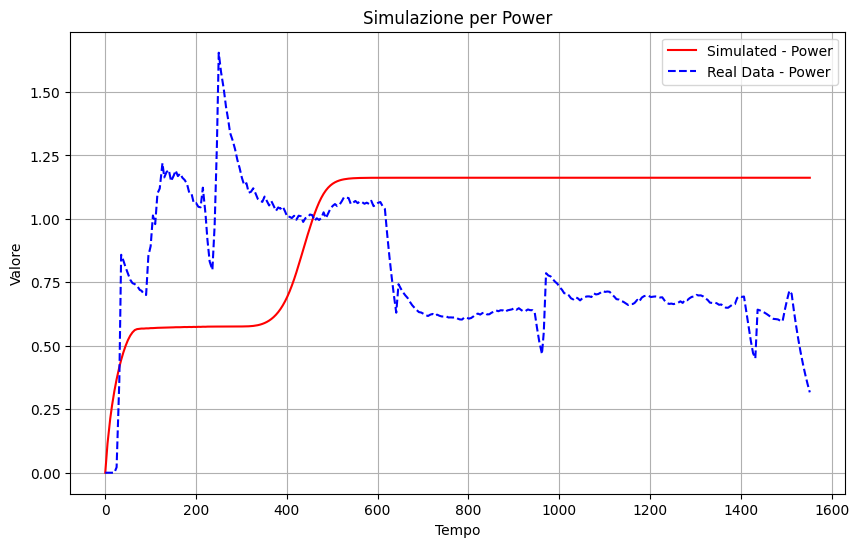

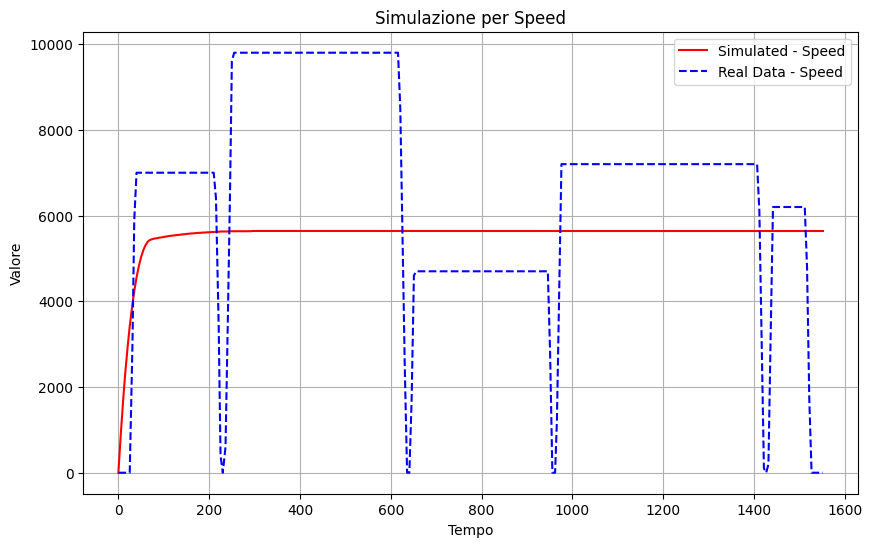

In [ ]:
plot_versus_features(x_train, t_power, x_learned, t_power, feature_names)

##Implementazione Regressore

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(train_speed.reshape(-1, 1), train_power)
best_params = grid_search.best_params_
print("Parametri ottimali:", best_params)

Parametri ottimali: {'C': 100, 'gamma': 1e-05}


In [ ]:
regressor = SVR(kernel='rbf', C=100, gamma=0.00001)
regressor.fit(train_speed.reshape(-1, 1), train_power)

SVR(C=100, gamma=1e-05)

In [ ]:
predictions = regressor.predict(test_speed.reshape(-1, 1))
mse = mean_squared_error(test_power, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.016821114509922214


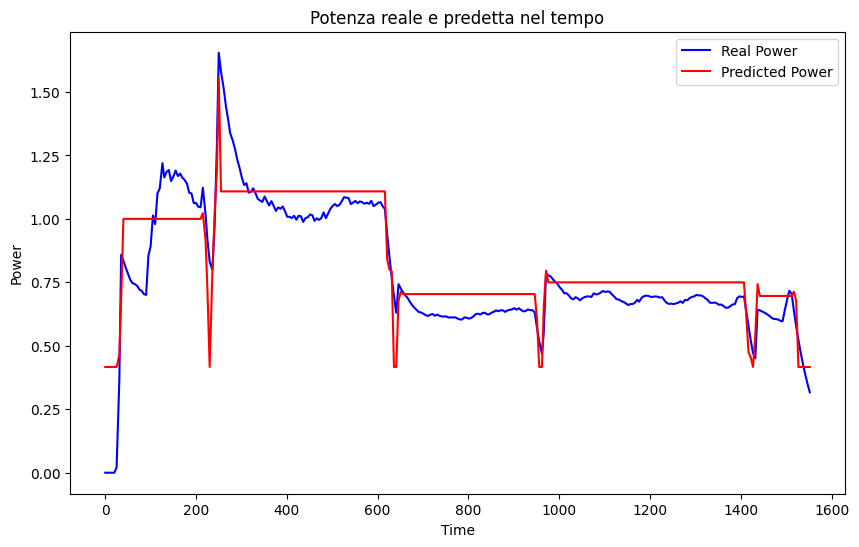

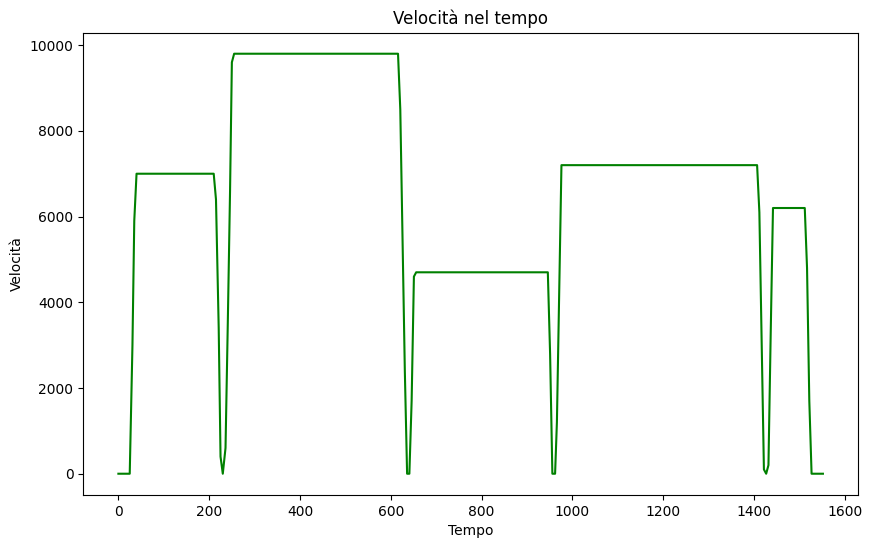

In [ ]:
import matplotlib.pyplot as plt

predictions = regressor.predict(speed_data.reshape(-1, 1))
plt.figure(figsize=(10, 6))

plt.plot(t_power, power_data, label='Real Power', color='blue')
plt.plot(t_power, predictions, label='Predicted Power', color='red')

plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Potenza reale e predetta nel tempo')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_speed, speed_data, color='green')
plt.xlabel('Tempo')
plt.ylabel('Velocità')
plt.title('Velocità nel tempo')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Definizione dei parametri da cercare
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Costruzione del regressore XGBoost
xgb_regressor = XGBRegressor()

# Ricerca a griglia
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Stampare i migliori parametri
print("Best parameters:", grid_search.best_params_)

# Valutazione del modello con i migliori parametri
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


KeyboardInterrupt: 

##Implementazione rete neurali

In [ ]:
max_length = max(max(len(segment) for segment in speed_segments),
                 max(len(segment) for segment in power_segments))

# Funzione per effettuare il padding delle sequenze con zeri
def pad_sequences(sequences, max_length):
    padded_sequences = []
    for sequence in sequences:
        # Calcola il numero di zeri da aggiungere
        num_zeros = max_length - len(sequence)
        # Effettua il padding con zeri
        padded_sequence = np.pad(sequence, (0, num_zeros), 'constant')
        padded_sequences.append(padded_sequence)
    return padded_sequences

# Applica il padding alle sequenze di velocità e potenza
X_padded = pad_sequences(speed_segments, max_length)
y_padded = pad_sequences(power_segments, max_length)

# Converti le liste di segmenti di velocità e potenza in array numpy
X = np.array(X_padded)
y = np.array(y_padded)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###LSTM simple

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import TimeDistributed

model = Sequential([
    LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True),  # Return_sequences=True per ottenere output per ogni passo temporale
    TimeDistributed(Dense(units=1))  # Output per ogni passo temporale
])


# Compilazione del modello
model.compile(optimizer='adam', loss='mse')

# Addestramento del modello
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0244
Epoch 2/10
1/1 [==============================] - 0s 94ms/step - loss: 0.0174
Epoch 3/10
1/1 [==============================] - 0s 100ms/step - loss: 0.0152
Epoch 4/10
1/1 [==============================] - 0s 94ms/step - loss: 0.0154
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.0147
Epoch 6/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0140
Epoch 7/10
1/1 [==============================] - 0s 85ms/step - loss: 0.0138
Epoch 8/10
1/1 [==============================] - 0s 99ms/step - loss: 0.0140
Epoch 9/10
1/1 [==============================] - 0s 80ms/step - loss: 0.0139
Epoch 10/10
1/1 [==============================] - 0s 87ms/step - loss: 0.0146


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predictions = model.predict(X_test)
predictions_reshaped = predictions.reshape(-1, predictions.shape[1])

# Calcola le metriche di valutazione
mse = mean_squared_error(y_test, predictions_reshaped)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions_reshaped)
r2 = r2_score(y_test, predictions_reshaped)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

1/1 [==============================] - 0s 26ms/step
Mean Squared Error (MSE): 0.12054400260682152
Root Mean Squared Error (RMSE): 0.3471944737561667
Mean Absolute Error (MAE): 0.30668546851920775


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


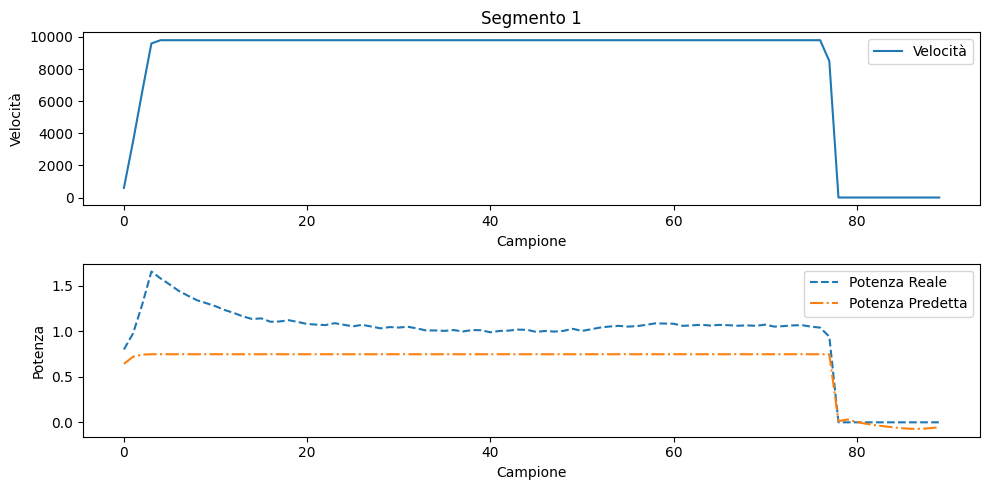

In [ ]:
import matplotlib.pyplot as plt

# Numero di segmenti
num_segments = len(X_test)

# Ciclo attraverso ogni segmento
for i in range(num_segments):
    # Estrai il segmento di velocità, potenza reale e potenza predetta
    speed_segment = X_test[i]
    true_power_segment = y_test[i]
    predicted_power_segment = predictions_reshaped[i]

    # Plot del segmento di velocità
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(speed_segment, label='Velocità')
    plt.title(f'Segmento {i+1}')
    plt.xlabel('Campione')
    plt.ylabel('Velocità')
    plt.legend()

    # Plot del segmento di potenza
    plt.subplot(2, 1, 2)
    plt.plot(true_power_segment, label='Potenza Reale', linestyle='--')
    plt.plot(predicted_power_segment, label='Potenza Predetta', linestyle='-.')
    plt.xlabel('Campione')
    plt.ylabel('Potenza')
    plt.legend()

    plt.tight_layout()
    plt.show()


###LSTM complex

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras import regularizers

def build_lstm_model(input_shape):
    units = 64
    dropout_rate = 0.2
    kernel_regularizer = regularizers.l2(0.01)

    model = Sequential([
        LSTM(units=units, input_shape=input_shape, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        LSTM(units=units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(units=units, activation='relu', kernel_regularizer=kernel_regularizer),
        Dropout(dropout_rate),
        TimeDistributed(Dense(units=1))
    ])
    return model

# Costruzione del modello LSTM con parametri fissi
model = build_lstm_model(input_shape=(X_train.shape[1], 1))


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9540 - val_loss: 1.0836
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.9713 - val_loss: 0.9429
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.8757 - val_loss: 0.8563
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.8023 - val_loss: 0.7765
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.7870 - val_loss: 0.7067
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.7553 - val_loss: 0.6516
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.7529 - val_loss: 0.6168
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.7604 - val_loss: 0.6042
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.6439 - val_loss: 0.6040
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.7130 - val_loss: 0.6130
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.6582 - val_loss: 0.6156
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.73

In [ ]:
def build_dropout_model(input_shape):
    model = Sequential([
        LSTM(units=64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        Dense(units=64, activation='relu'),
        Dropout(0.2),
        TimeDistributed(Dense(units=1))
    ])
    return model

model = build_dropout_model(input_shape=(X_train.shape[1], 1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])

mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1904 - val_loss: 0.0822
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1028 - val_loss: 0.0099
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0661 - val_loss: 0.0361
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0736 - val_loss: 0.0663
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0891 - val_loss: 0.0553
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0681 - val_loss: 0.0322
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0500 - val_loss: 0.0125
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0530 - val_loss: 0.0065
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0424 - val_loss: 0.0089
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0459 - val_loss: 0.0133
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0422 - val_loss: 0.0160
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0478

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor

def create_model(activation='relu', dropout_rate=0.0, kernel_initializer='uniform', optimizer='adam'):
    model = Sequential()
    model.add(Dense(12, input_shape=(8,), kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=kernel_initializer))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model



model = KerasRegressor(build_fn=create_model, verbose=0)

activation = ['relu', 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [50, 100, 150]

param_grid = dict(activation=activation, dropout_rate=dropout_rate, kernel_initializer=kernel_initializer, optimizer=optimizer, batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


##Last

[<sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feaf80>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feaf50>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feb040>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feae30>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feadd0>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55fead70>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55fead10>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feacb0>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feac50>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feabf0>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feb070>, <sha_learning.domain.sigfeatures.ChangePoint object at 0x7a3d55feb0d0>]
